In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

/home/runner/work/visread/visread/docs/tutorials/notebook_setup.py:21: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('config InlineBackend.figure_format = "retina"')


# Walkthrough: Examining DSHARP AS 209 Weights and Exporting Visibilities

In this walkthrough tutorial, we'll use CASA tools to examine the visibilities, visibility residuals, and weights of a real multi-configuration dataset from the DSHARP survey.

## Obtaining and CLEANing the AS 209 measurement set

The calibrated measurement sets from the DSHARP data release are available [online](https://almascience.eso.org/almadata/lp/DSHARP/), and the full description of the survey is provided in [Andrews et al. 2018](https://ui.adsabs.harvard.edu/abs/2018ApJ...869L..41A/abstract).

### Model Visibilities and MODEL_DATA
In its simplest form, the measurement set just contains the visibility data in a ``DATA`` or ``CORRECTED_DATA`` column. In the process of using ``tclean`` to synthesize an image, however, CASA also calculates a set of model visibilities that correspond to the Fourier transform of the CLEAN model. It's possible to store these model visibilities to the measurement set if the ``tclean`` process was invoked with the ``savemodel="modelcolumn"`` parameter. The model visibilities will be stored in a ``MODEL_DATA`` column with the same shape as the ``DATA`` column.

The calibrated DSHARP measurement sets available from the archive do not contain this ``MODEL_DATA`` column (most likely for space reasons), so we will need to recreate them by running the ``tclean`` algorithm with the relevant settings. The full reduction scripts are [available online](https://almascience.eso.org/almadata/lp/DSHARP/scripts/AS209_continuum.py), but we just need reproduce the relevant ``tclean`` commands used to produce a FITS image from the final, calibrated measurement set.

Because the measurement set is large (0.9 Gb) and the ``tclean`` process is computationally expensive (taking about 1 hr on a single core), we have pre-executed those commands and cached the measurement set and ``tclean`` products into the ``AS209_MS`` local directory. If you're interested in the exact ``tclean`` commands used, please check out the [dl_and_tclean_AS209.py](dl_and_tclean_AS209.py) script directly.

In [3]:
import re
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os

In [4]:
from traitlets.traitlets import validate

In [5]:
# change to the cached subdirectory that contains the cleaned MS
workdir = "AS209_MS"
os.chdir(workdir)
fname = "AS209_continuum.ms"
fitsname = "AS209.fits"

### Visualizing the CLEANed image
Just to make sure the ``tclean`` process ran OK, let's check the synthesized image that was produced

In [6]:
from astropy.io import fits

In [7]:
hdul = fits.open(fitsname)
header = hdul[0].header
data = 1e3 * hdul[0].data  # mJy/pixel
# get the coordinate labels
nx = header["NAXIS1"]
ny = header["NAXIS2"]
# RA coordinates
CDELT1 = 3600 * header["CDELT1"]  # arcsec (converted from decimal deg)
CRPIX1 = header["CRPIX1"] - 1.0  # Now indexed from 0
# DEC coordinates
CDELT2 = 3600 * header["CDELT2"]  # arcsec
CRPIX2 = header["CRPIX2"] - 1.0  # Now indexed from 0
RA = (np.arange(nx) - nx / 2) * CDELT1  # [arcsec]
DEC = (np.arange(ny) - ny / 2) * CDELT2  # [arcsec]
# extent needs to include extra half-pixels.
# RA, DEC are pixel centers
ext = (
    RA[0] - CDELT1 / 2,
    RA[-1] + CDELT1 / 2,
    DEC[0] - CDELT2 / 2,
    DEC[-1] + CDELT2 / 2,
)  # [arcsec]
norm = matplotlib.colors.Normalize(vmin=0, vmax=np.max(data))

Text(0, 0.5, '$\\Delta \\delta$ [${}^{\\prime\\prime}$]')

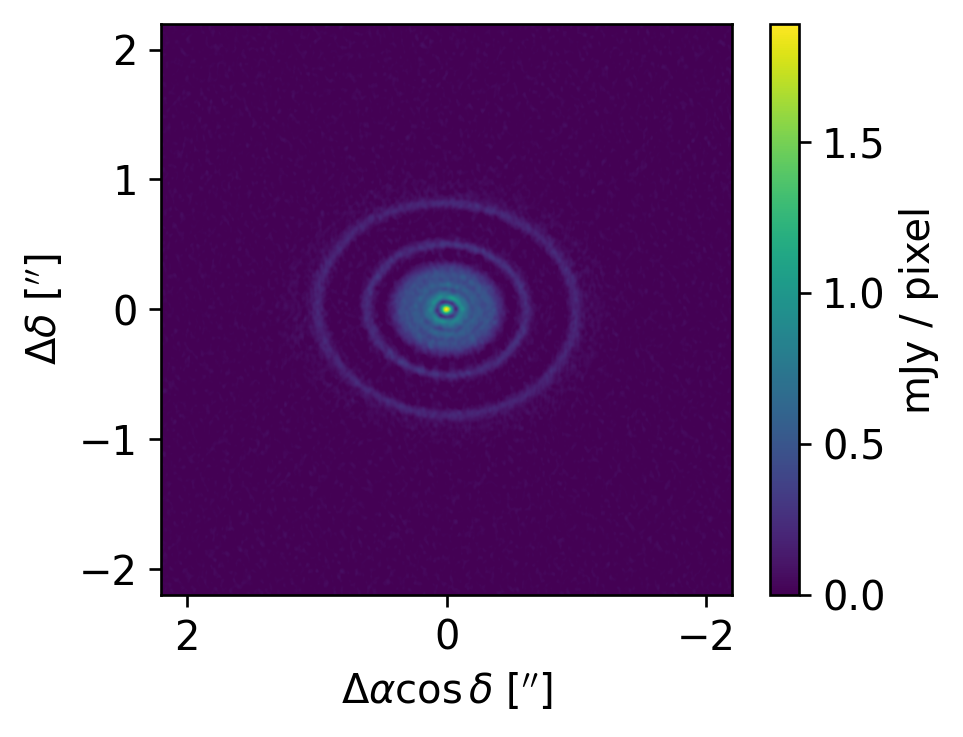

In [8]:
fig, ax = plt.subplots(nrows=1, figsize=(4.5, 3.5))
fig.subplots_adjust(left=0.2, bottom=0.2)
im = ax.imshow(data, extent=ext, origin="lower", animated=True, norm=norm)
cb = plt.colorbar(im, label="mJy / pixel")
r = 2.2
ax.set_xlim(r, -r)
ax.set_ylim(-r, r)
ax.set_xlabel(r"$\Delta \alpha \cos \delta$ [${}^{\prime\prime}$]")
ax.set_ylabel(r"$\Delta \delta$ [${}^{\prime\prime}$]")

Great, it looks like things check out. Note that the main reason (at least for this tutorial) that we ran ``tclean`` was to generate the ``MODEL_DATA`` column in the measurement set. The actual CLEANed FITS image is just a nice byproduct.

## Examining measurement set structure

Before you dive into the full analysis with CASA tools, it's a very good idea to inspect the measurement set using [listobs](https://casa.nrao.edu/casadocs-devel/stable/global-task-list/task_listobs/about).

After you've done that, let's start exploring the visibility values. First we'll need to import and then instantiate the relevant CASA tools, [table](https://casa.nrao.edu/casadocs-devel/stable/global-tool-list/tool_table/methods) and [ms](https://casa.nrao.edu/casadocs-devel/stable/global-tool-list/tool_ms/methods).

In [9]:
import casatools

In [10]:
tb = casatools.table()
ms = casatools.ms()

We can get the indexes of the unique spectral windows, which are typically indexed by the ``DATA_DESC_ID``.

In [11]:
tb.open(fname + "/DATA_DESCRIPTION")
SPECTRAL_WINDOW_ID = tb.getcol("SPECTRAL_WINDOW_ID")
tb.close()
print(SPECTRAL_WINDOW_ID)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]


We see that there are 25 separate spectral windows! This is because the DSHARP images were produced using all available Band 6 continuum data on each source---not just the long baseline observations acquired in ALMA cycle 4. The merging of all of these individual observations is what creates this structure with so many spectral windows.

Next, let's open the main table of the measurement set and inspect the column names

In [12]:
tb.open(fname)
colnames = tb.colnames()
tb.close()
print(colnames)

['UVW', 'FLAG', 'FLAG_CATEGORY', 'WEIGHT', 'SIGMA', 'ANTENNA1', 'ANTENNA2', 'ARRAY_ID', 'DATA_DESC_ID', 'EXPOSURE', 'FEED1', 'FEED2', 'FIELD_ID', 'FLAG_ROW', 'INTERVAL', 'OBSERVATION_ID', 'PROCESSOR_ID', 'SCAN_NUMBER', 'STATE_ID', 'TIME', 'TIME_CENTROID', 'DATA', 'WEIGHT_SPECTRUM', 'SIGMA_SPECTRUM', 'MODEL_DATA']


Because there are multiple spectral windows which do not share the same dimensions, we cannot use the ``tb`` tool to read the data directly. If we try, we'll get an error.

In [13]:
try:
    tb.open(fname)
    weight = tb.getcol("WEIGHT")  # array of float64 with shape [npol, nvis]
    flag = tb.getcol("FLAG")  # array of bool with shape [npol, nchan, nvis]
    data = tb.getcol("DATA")  # array of complex128 with shape [npol, nchan, nvis]
except RuntimeError:
    print(
        "We can't use table tools here... the spws have different numbers of channels"
    )
finally:
    tb.close()

So, we'll need to use the ``ms`` tool to read the visibilities for each spectral window, like so

In [14]:
ms.open(fname)
# select the spectral window
ms.selectinit(datadescid=0)
# query the desired columnames as a list
query = ms.getdata(["WEIGHT", "UVW", "DATA"])
# always a good idea to reset the earmarked data
ms.selectinit(reset=True)
ms.close()

True

The returned query is a dictionary whose keys are the lowercase column names

In [15]:
print(query.keys())

dict_keys(['data', 'uvw', 'weight'])


and whose values are the numerical arrays for the spectral window that we queried

In [16]:
print(query["data"])

[[[-0.09359986-0.07905877j  0.19716288+0.10789031j
   -0.04736413-0.38649508j ...  0.4015328 +0.23623116j
    0.20422684+0.29638007j  0.13025568-0.55658323j]]

 [[ 0.43320566-0.16495545j -0.0630829 -0.10485866j
   -0.36411372-0.40655291j ...  0.24039683-0.32688245j
    0.46174076-0.27798796j  0.61960417+0.00973242j]]]


## Using the tclean model to calculate residual visibilities

In any data analysis where you're computing a forward model, it's a good consitency check to examine the data residuals from that model, and, in particular, whether their scatter matches the expectations from the noise properties.

We can calculate data residuals using the model visibilities derived from the tclean model and stored in the ``MODEL_DATA`` column of the measurement set.

In [17]:
ms.open(fname)
# select the spectral window
ms.selectinit(datadescid=0)
# query the desired columnames as a list
query = ms.getdata(["MODEL_DATA"])
# always a good idea to reset the earmarked data
ms.selectinit(reset=True)
ms.close()

True

In [18]:
print(query["model_data"])

[[[0.05795327-0.00037503j 0.06064697-0.0005148j  0.03213371-0.0003984j
   ... 0.05897298-0.00039497j 0.06831173-0.00042475j
   0.19711027-0.00065186j]]

 [[0.05795327-0.00037503j 0.06064697-0.0005148j  0.03213371-0.0003984j
   ... 0.05897298-0.00039497j 0.06831173-0.00042475j
   0.19711027-0.00065186j]]]


Using these model visibilities, let's calculate the residuals for each polarization (XX, YY) in units of $\sigma$, where

$$
\sigma = \mathrm{sigma\_rescale} \times \sigma_0
$$

and

$$
\sigma_0 = \sqrt{1/w}
$$

The scatter is defined as

$$
\mathrm{scatter} = \frac{\mathrm{DATA} - \mathrm{MODEL\_DATA}}{\sigma}
$$

For now, $\mathrm{sigma\_rescale} = 1$, but we'll see why this parameter is needed in a moment.

### Helper functions for examining weight scatter
Because we'd like to repeat this analysis for each spectral window in the measurement set, it makes things easier if we write these calculations as functions.

The functions provided in this document are only dependent on the CASA tools ``tb`` and ``ms``. If you find yourself using these routines frequently, you might consider installing the *visread* package, since similar commands are provided in the API.

In [19]:
def get_scatter_datadescid(datadescid, sigma_rescale=1.0, apply_flags=True):
    """
    Calculate the scatter for each polarization.

    Args:
        datadescid (int): the DATA_DESC_ID to be queried
        sigma_rescale (int):  multiply the uncertainties by this factor
        apply_flags (bool): calculate the scatter *after* the flags have been applied

    Returns:
        scatter_XX, scatter_YY: a 2-tuple of numpy arrays containing the scatter in each polarization.
        If ``apply_flags==True``, each array will be 1-dimensional. If ``apply_flags==False``, each array
        will retain its original shape, including channelization (e.g., shape ``nchan,nvis``).
    """
    ms.open(fname)
    # select the key
    ms.selectinit(datadescid=datadescid)
    query = ms.getdata(
        ["DATA", "MODEL_DATA", "WEIGHT", "UVW", "ANTENNA1", "ANTENNA2", "FLAG"]
    )
    ms.selectinit(reset=True)
    ms.close()

    data, model_data, weight, flag = (
        query["data"],
        query["model_data"],
        query["weight"],
        query["flag"],
    )

    assert (
        len(model_data) > 0
    ), "MODEL_DATA column empty, retry tclean with savemodel='modelcolumn'"

    # subtract model from data
    residuals = data - model_data

    # calculate sigma from weight
    sigma = np.sqrt(1 / weight)
    sigma *= sigma_rescale

    # divide by weight, augmented for channel dim
    scatter = residuals / sigma[:, np.newaxis, :]

    # separate polarizations
    scatter_XX, scatter_YY = scatter
    flag_XX, flag_YY = flag

    if apply_flags:
        # flatten across channels
        scatter_XX = scatter_XX[~flag_XX]
        scatter_YY = scatter_YY[~flag_YY]

    return scatter_XX, scatter_YY

In [20]:
def gaussian(x, sigma=1):
    r"""
    Evaluate a reference Gaussian as a function of :math:`x`

    Args:
        x (float): location to evaluate Gaussian

    The Gaussian is defined as

    .. math::

        f(x) = \frac{1}{\sqrt{2 \pi}} \exp \left ( -\frac{x^2}{2}\right )

    Returns:
        Gaussian function evaluated at :math:`x`
    """
    return 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-0.5 * (x / sigma) ** 2)

In [21]:
def scatter_hist(scatter_XX, scatter_YY, log=False, **kwargs):
    """
    Plot a normalized histogram of scatter for real and imaginary
    components of XX and YY polarizations.

    Args:
        scatter_XX (1D numpy array)
        scatter_YY (1D numpy array)

    Returns:
        matplotlib figure
    """
    xs = np.linspace(-5, 5)

    figsize = kwargs.get("figsize", (6, 6))
    bins = kwargs.get("bins", 40)

    fig, ax = plt.subplots(ncols=2, nrows=2, figsize=figsize)
    ax[0, 0].hist(scatter_XX.real, bins=bins, density=True, log=log)
    ax[0, 0].set_xlabel(
        r"$\Re \{ V_\mathrm{XX} - \bar{V}_\mathrm{XX} \} / \sigma_\mathrm{XX}$"
    )
    ax[0, 1].hist(scatter_XX.imag, bins=bins, density=True, log=log)
    ax[0, 1].set_xlabel(
        r"$\Im \{ V_\mathrm{XX} - \bar{V}_\mathrm{XX} \} / \sigma_\mathrm{XX}$"
    )

    ax[1, 0].hist(scatter_YY.real, bins=bins, density=True, log=log)
    ax[1, 0].set_xlabel(
        r"$\Re \{ V_\mathrm{YY} - \bar{V}_\mathrm{YY} \} / \sigma_\mathrm{YY}$"
    )
    ax[1, 1].hist(scatter_YY.imag, bins=bins, density=True, log=log)
    ax[1, 1].set_xlabel(
        r"$\Im \{ V_\mathrm{YY} - \bar{V}_\mathrm{YY} \} / \sigma_\mathrm{YY}$"
    )

    for a in ax.flatten():
        a.plot(xs, gaussian(xs))

    fig.subplots_adjust(hspace=0.25, top=0.92)

    return fig

In [22]:
def plot_histogram_datadescid(
    datadescid, sigma_rescale=1.0, log=False, apply_flags=True
):
    """Wrap the scatter routine to plot a histogram of scatter for real and imaginary components of XX and YY polarizations, given a ``DATA_DESC_ID``.

    Args:
        datadescid (int): the DATA_DESC_ID to be queried
        sigma_rescale (int):  multiply the uncertainties by this factor
        log (bool): plot the histogram with a log stretch
        apply_flags (bool): calculate the scatter *after* the flags have been applied


    Returns:
        matplotlib figure
    """

    scatter_XX, scatter_YY = get_scatter_datadescid(
        datadescid=datadescid, sigma_rescale=sigma_rescale, apply_flags=apply_flags
    )

    scatter_XX = scatter_XX.flatten()
    scatter_YY = scatter_YY.flatten()

    fig = scatter_hist(scatter_XX, scatter_YY, log=log)
    fig.suptitle("DATA_DESC_ID: {:}".format(datadescid))

## Checking scatter for each spectral window
Now lets use our helper functions to investigate the characteristics of each spectral window.

### Spectral Window 7: A correctly scaled SPW
Let's see how the residual visibilities in spectral window 7 scatter relative to their expected Gaussian envelope

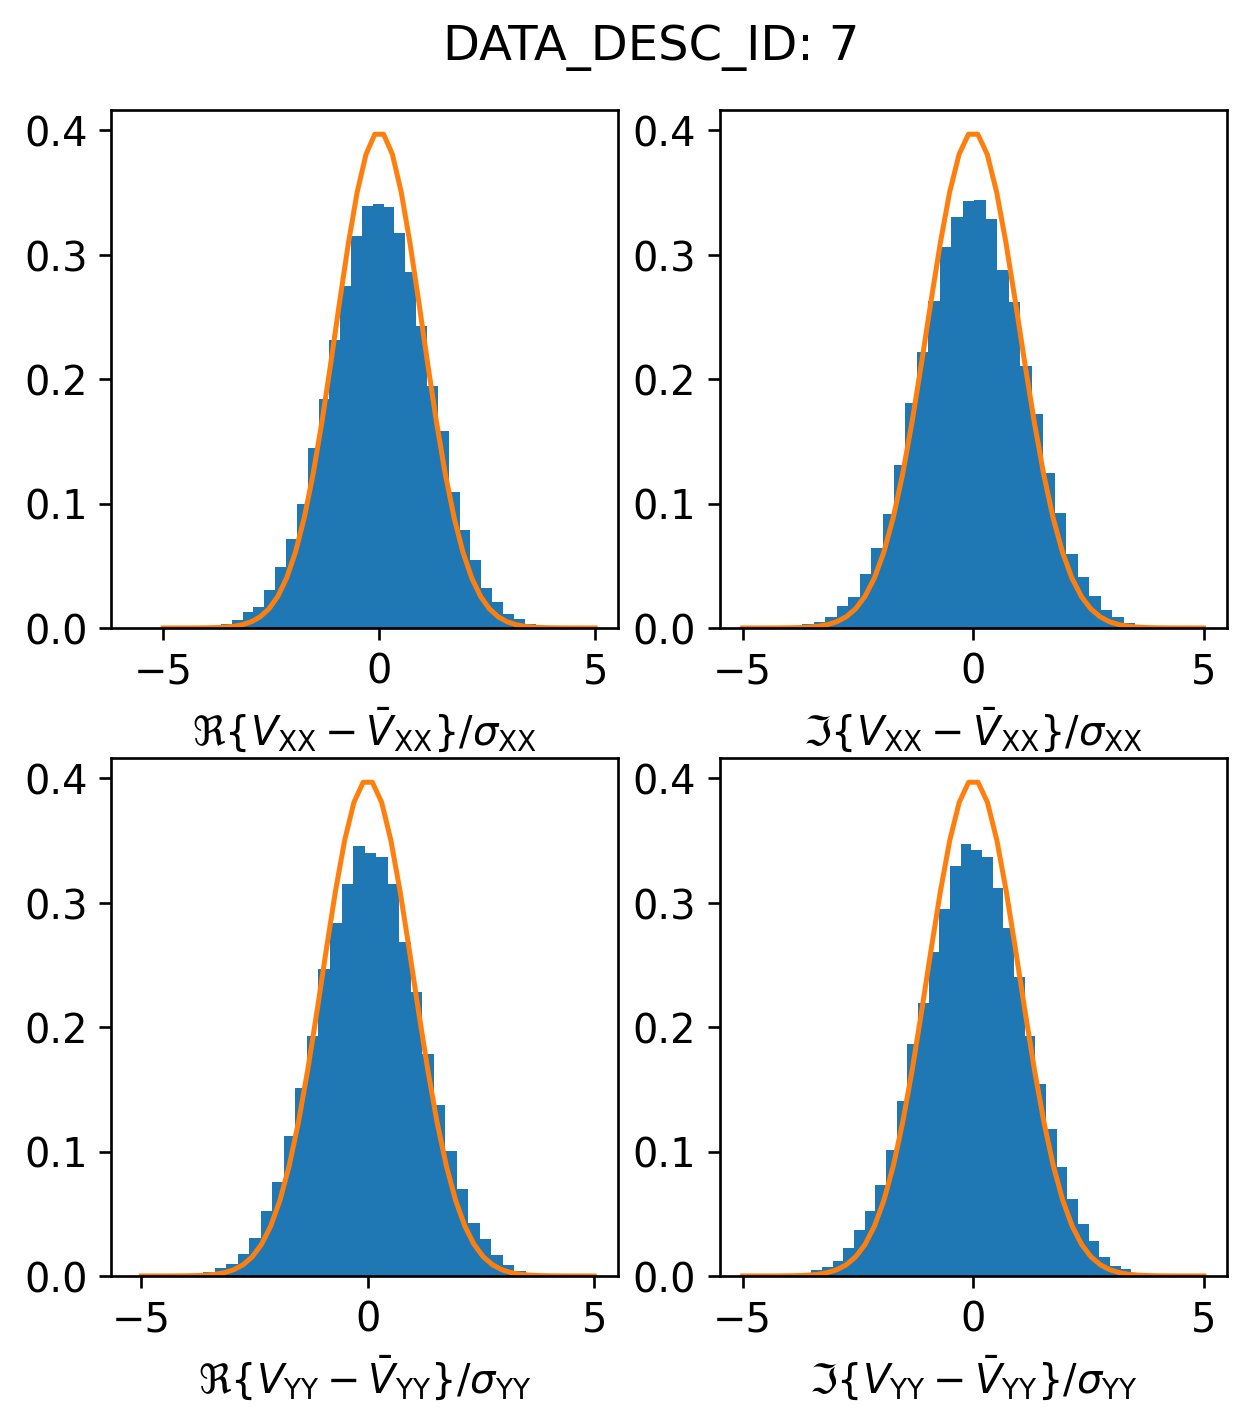

In [23]:
plot_histogram_datadescid(7, apply_flags=False)

Great, it looks like things are pretty much as we would expect here.

### Spectral Window 22: Visibility outliers
In the last example, we were a little bit cavalier and plotted the residuals for *all* visibilities, regardless of whether their ``FLAG`` was true. If we do the same for the visibilities in spectral window 22,

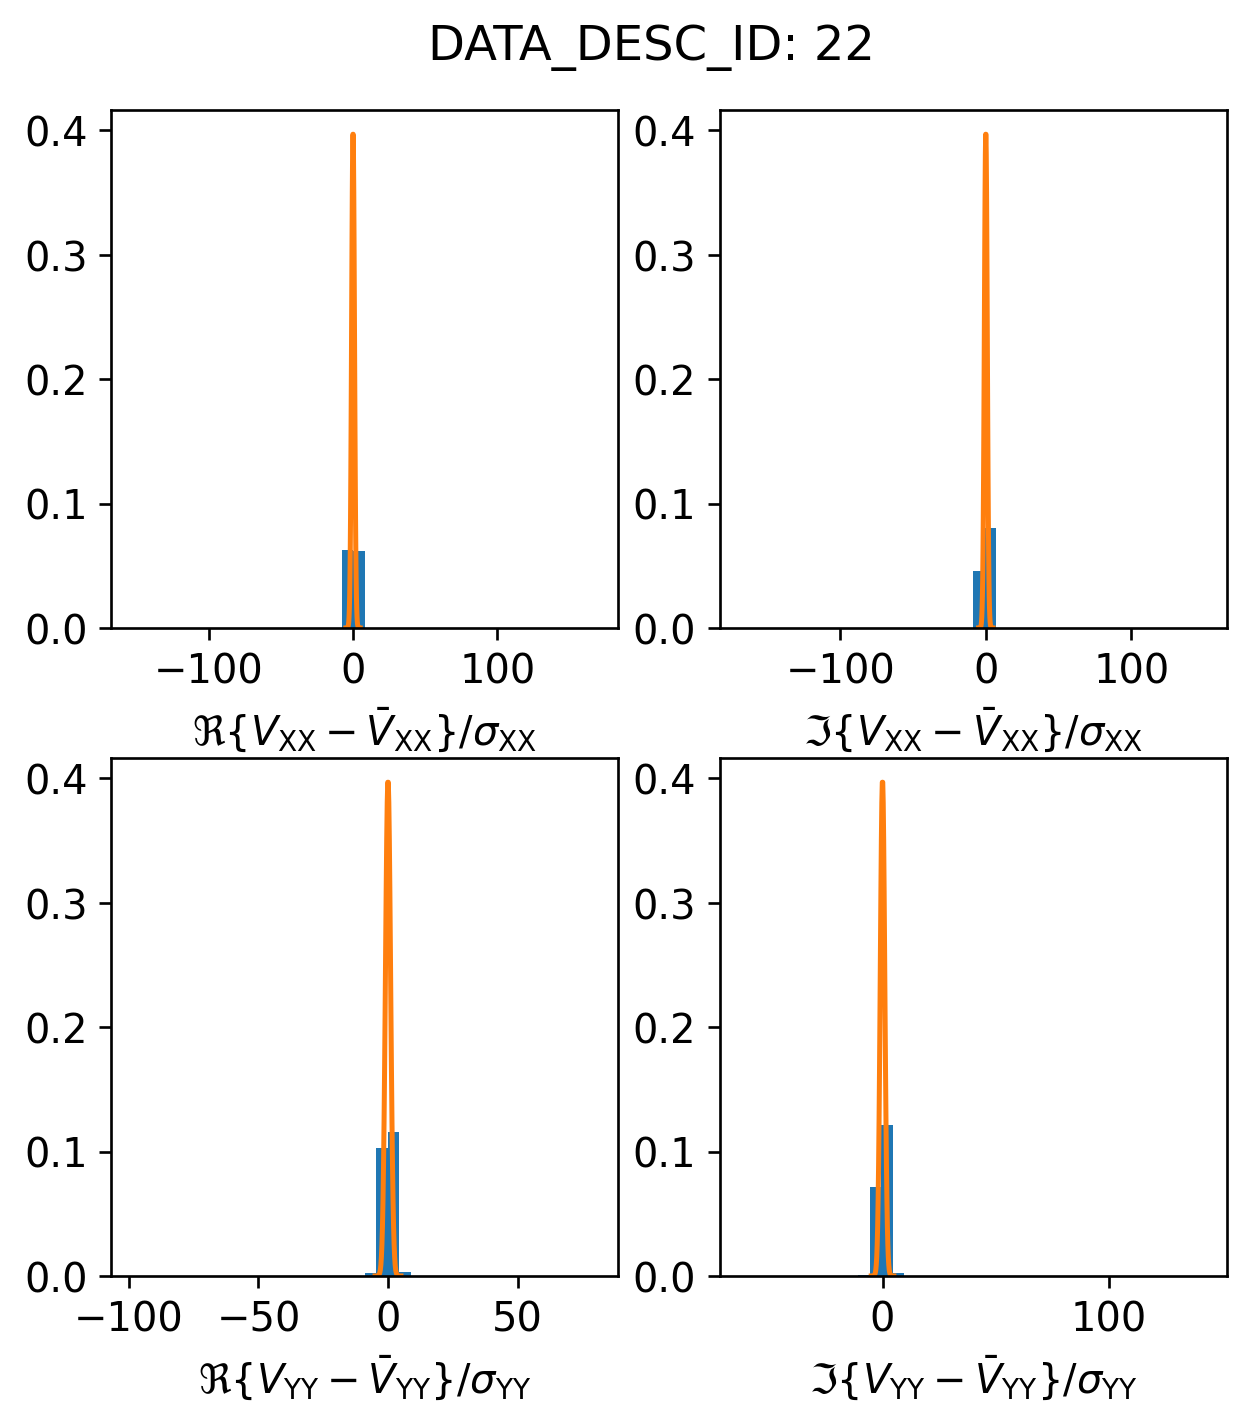

In [24]:
plot_histogram_datadescid(22, apply_flags=False)

We find that something looks a little bit strange. Let's try plotting things on a log scale to get a closer look.

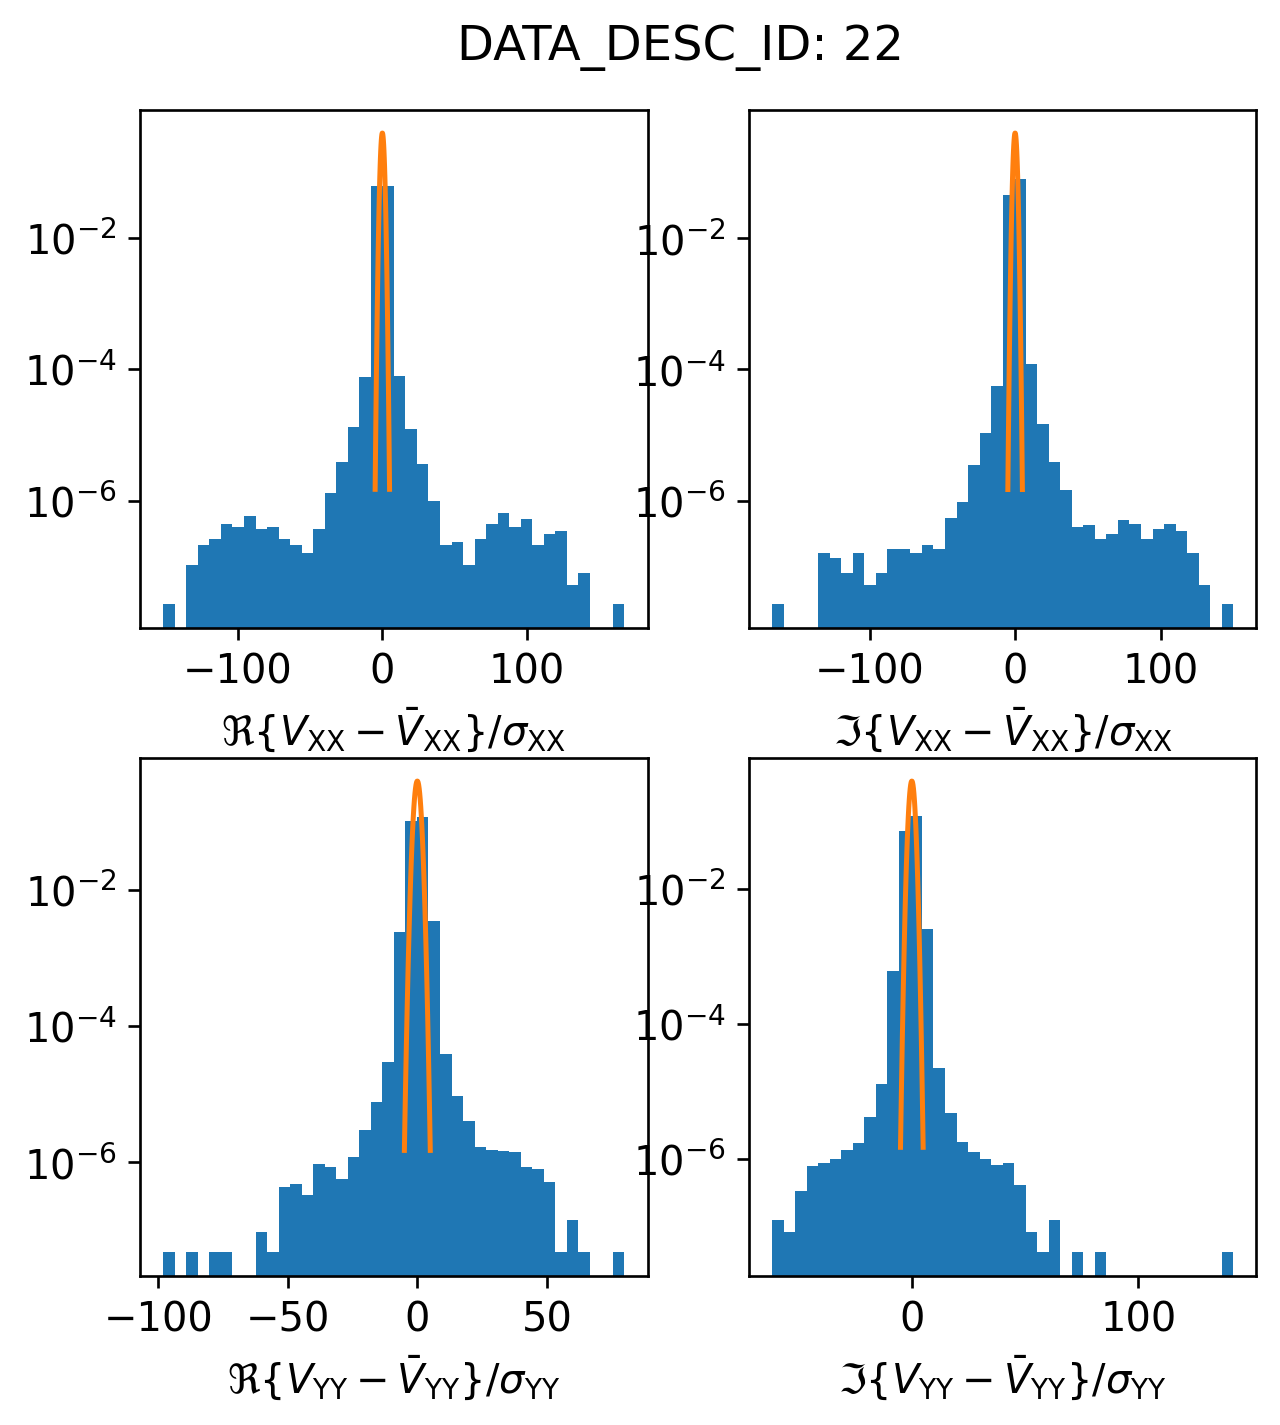

In [25]:
plot_histogram_datadescid(22, apply_flags=False, log=True)

It appears as though there are a bunch of "outlier" visibilities included in this spectral window (the histogram y-axis is the relative frequency or probability density, so in actually there are a relatively small number of outlier visibilities). If the calibration and data preparation processes were done correctly, most likely, these visibilities are actually flagged. Let's try plotting only the valid, unflagged, visibilities

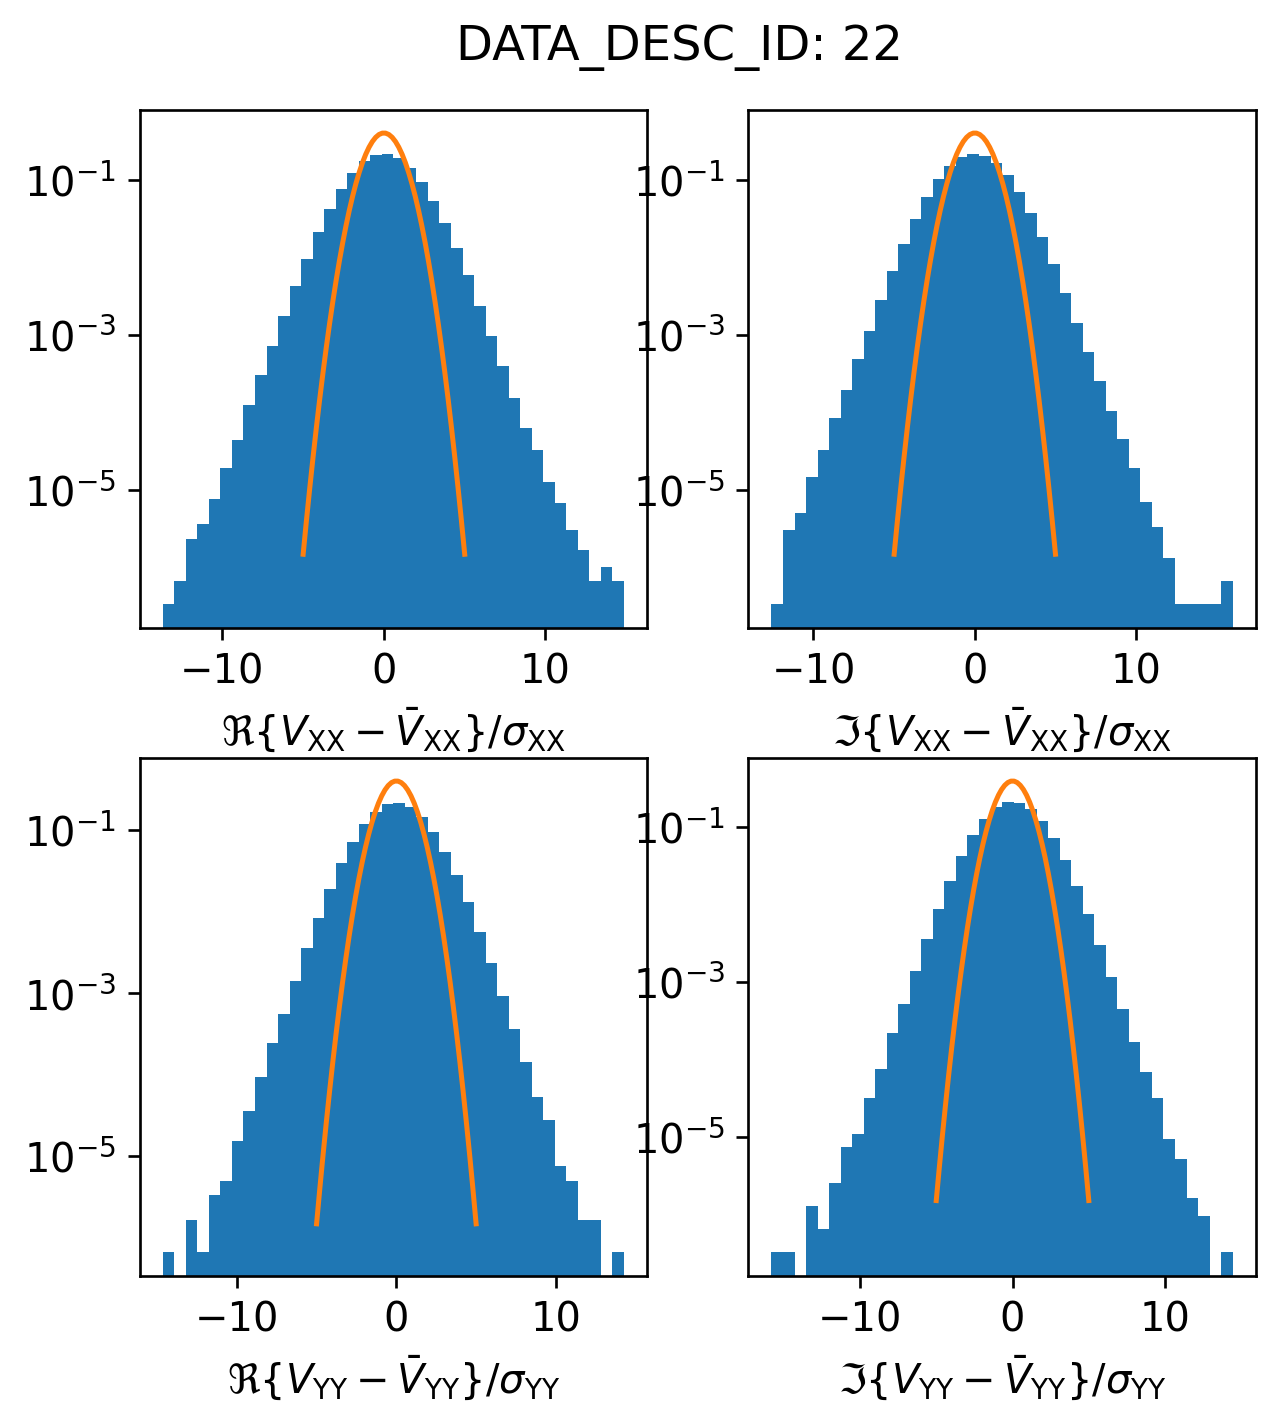

In [26]:
plot_histogram_datadescid(22, apply_flags=True, log=True)

This is certainly an improvement, it looks like all of the egregious outlier visibilities were correctly flagged. However, we also see that the scatter in the visibility residuals is overdispersed relative to the envelope we would expect from the supplied weights. Plotting this on a normal scale might make the discrepancy more visible

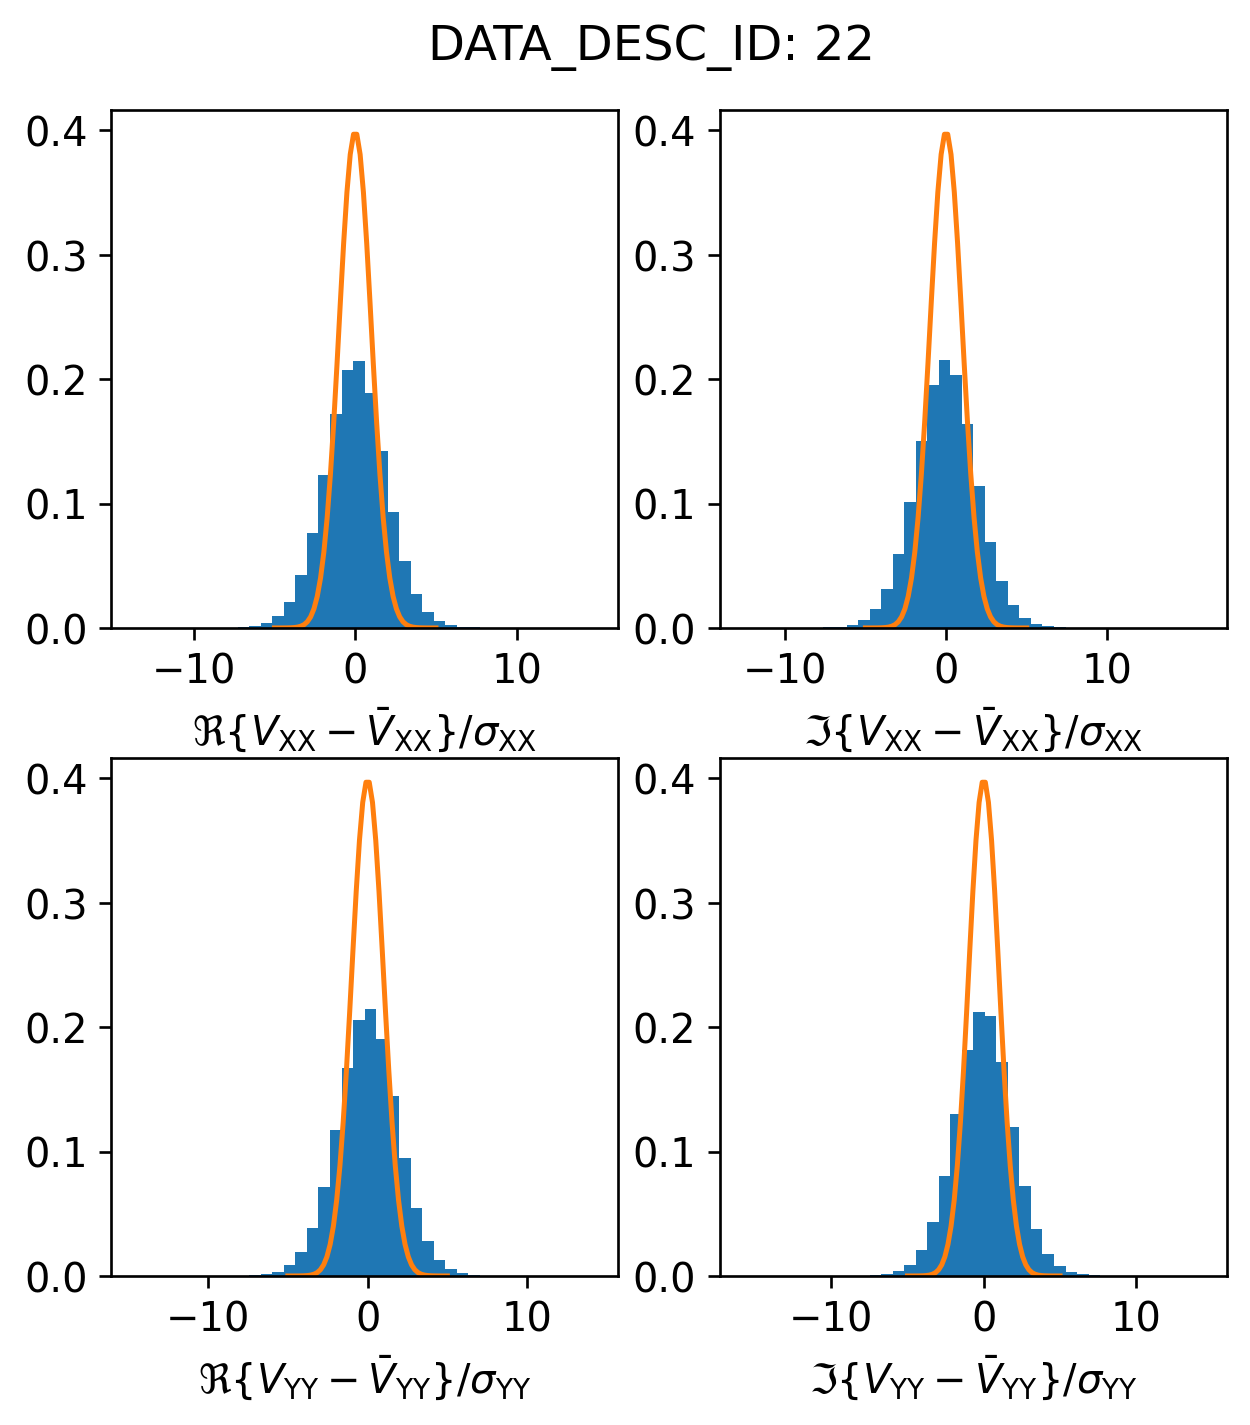

In [27]:
plot_histogram_datadescid(22, apply_flags=True, log=False)

Lets write a routine to estimate by how much the $\sigma_0$ values would need to be rescaled in order for the residual visibility scatter to match the expected reference Gaussian.

In [28]:
from scipy.optimize import minimize

In [29]:
def calculate_rescale_factor(scatter, **kwargs):
    bins = kwargs.get("bins", 40)
    bin_heights, bin_edges = np.histogram(scatter, density=True, bins=bins)
    bin_centers = bin_edges[:-1] + np.diff(bin_edges) / 2

    # find the sigma_rescale which minimizes the mean squared error
    # between the bin_heights and the expectations from the
    # reference Gaussian

    loss = lambda x: np.sum((bin_heights - gaussian(bin_centers, sigma=x)) ** 2)

    res = minimize(loss, 1.0)

    if res.success:
        return res.x[0]
    else:
        print(res)
        return False

In [30]:
def get_sigma_rescale_datadescid(datadescid, **kwargs):
    scatter_XX, scatter_YY = get_scatter_datadescid(
        datadescid, apply_flags=True, **kwargs
    )
    vals = np.array(
        [
            calculate_rescale_factor(scatter)
            for scatter in [
                scatter_XX.real,
                scatter_XX.imag,
                scatter_YY.real,
                scatter_YY.imag,
            ]
        ]
    )

    return np.average(vals)

In [31]:
factor = get_sigma_rescale_datadescid(22)
print(factor)

1.8596319521755138


If we rescale the $\sigma$ values to make them a factor of $\sim 1.85$ larger it looks like we are able to make the distributions match up a little bit better.

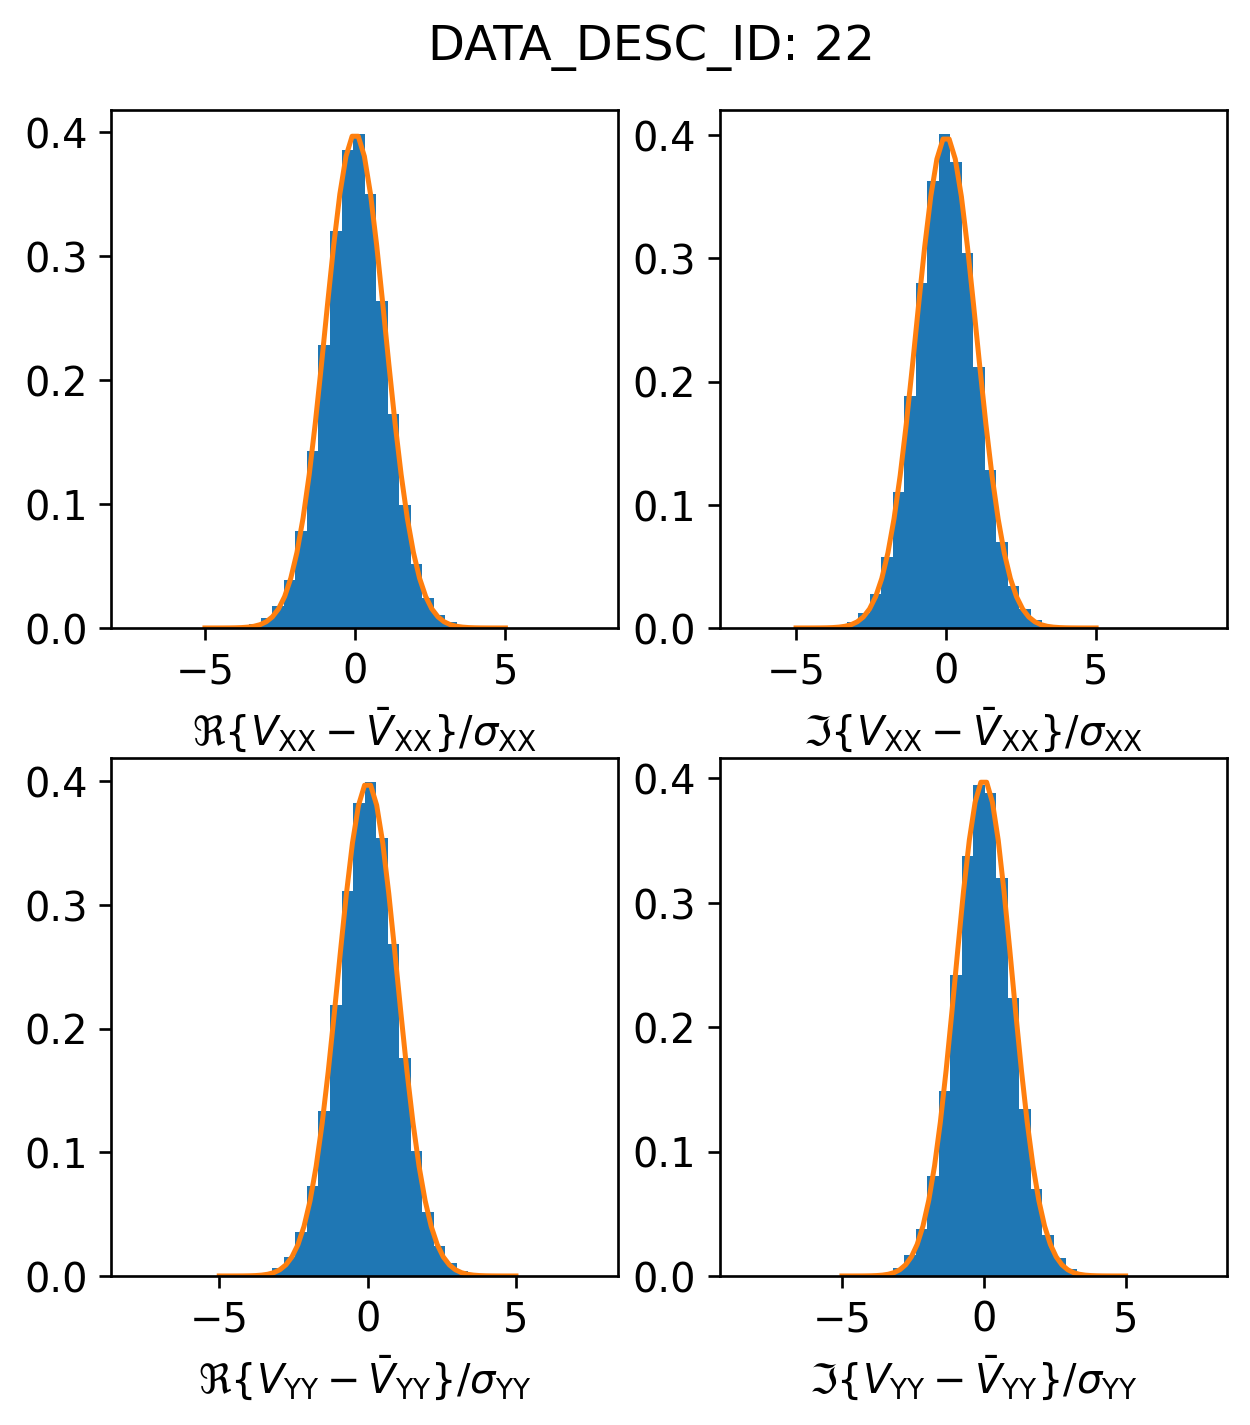

In [32]:
plot_histogram_datadescid(22, sigma_rescale=factor, apply_flags=True, log=False)

It's not really clear why this factor works, but factors of $\sqrt{2}$ and 2 appear in changes to the CASA weight calculations ([which have changed across recent CASA versions](https://casa.nrao.edu/casadocs-devel/stable/calibration-and-visibility-data/data-weights)). Since this DSHARP measurement set contains visibilities acquired in previous ALMA cycles (and potentially calibrated with earlier versions of CASA), these changes in weight definitions may be responsible for the varying weight scatter across spectral window.

To investigate the overdispersion in spectral window 22, lets plot up the rescaled visibilities in the $u,v$ plane, colorized by their residual values to see if we can discern any patterns that may be the result of an inadequate calibration or CLEAN model.

In [33]:
# get the baselines and flags for spectral window 22
ms.open(fname)
# select the key
ms.selectinit(datadescid=22)
query = ms.getdata(["UVW", "FLAG"])
ms.selectinit(reset=True)
ms.close()

True

In [34]:
flag_XX, flag_YY = query["flag"]
u, v, w = query["uvw"] * 1e-3  # [km]

In [35]:
# calculate the scatter of the residual visibilities
scatter_XX, scatter_YY = get_scatter_datadescid(
    22, sigma_rescale=factor, apply_flags=False
)

Let's check the array shapes of each of these.

In [36]:
print(flag_XX.shape)
print(scatter_XX.shape)
print(u.shape)

(16, 297935)
(16, 297935)
(297935,)


If we want to correctly apply the flags, we'll need to broadcast the baseline arrays to the full set of channels. (Even though this is a continuum dataset, it does have more than one channel to prevent bandwidth smearing).

In [37]:
nchan = flag_XX.shape[0]
broadcast = np.ones((nchan, 1))
uu = u * broadcast
vv = v * broadcast

Now we index the "good" visibilities

In [38]:
uu_XX = uu[~flag_XX]
vv_XX = vv[~flag_YY]
scatter_XX = scatter_XX[~flag_XX]

In [39]:
uu_YY = uu[~flag_YY]
vv_YY = vv[~flag_YY]
scatter_YY = scatter_YY[~flag_YY]

In [40]:
vvmax = 5
norm = matplotlib.colors.Normalize(vmin=-vvmax, vmax=vvmax)

Text(0, 0.5, '$v$ [km]')

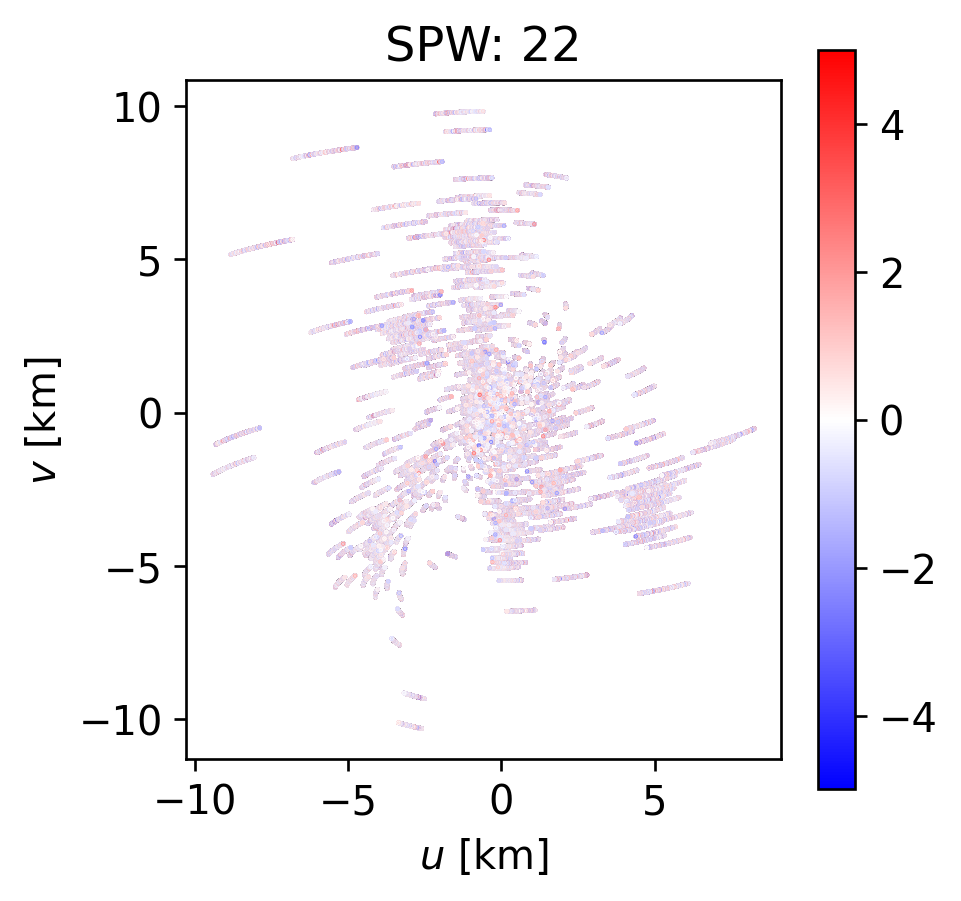

In [41]:
fig, ax = plt.subplots(nrows=1, figsize=(4, 4))
ax.scatter(uu_XX, vv_XX, s=0.1, c=scatter_XX.real, cmap="bwr", norm=norm)
im = ax.scatter(uu_YY, vv_YY, s=0.1, c=scatter_YY.real, cmap="bwr", norm=norm)
plt.colorbar(im, ax=ax)
ax.set_title("SPW: {:}".format(22))
ax.set_aspect("equal")
ax.set_xlabel(r"$u$ [km]")
ax.set_ylabel(r"$v$ [km]")

We don't appear to see any large scale pattern with baseline, suggesting that the CLEAN model is doing a reasonable job of fitting the data across many spatial scales. We do see some of the largest outliers (most blue/red) at the beginning (or end) of the tracks. This probably has something to do with a less-than-optimal calibration at the beginning (or end) of the observation. Since there are no large systematic trends with baseline, we'll just accept these rescaled weights as is.

## Rescaling weights for export.
We can use the previous routines to iterate through plots of each spectral window. For reference, here are the rescale factors we derived for each spectral window

In [42]:
sigma_rescale_factors = {
    ID: get_sigma_rescale_datadescid(ID) for ID in SPECTRAL_WINDOW_ID
}
for ID in SPECTRAL_WINDOW_ID:
    print(ID, "{:.2f}".format(sigma_rescale_factors[ID]))

0 1.21
1 1.20
2 1.25
3 1.15
4 1.15
5 1.14
6 1.15
7 1.15
8 1.15
9 1.78
10 1.28
11 1.80
12 1.28
13 1.88
14 1.77
15 1.77
16 1.80
17 1.88
18 1.89
19 1.89
20 1.99
21 1.85
22 1.86
23 1.88
24 1.95


If you wanted to use these visibilities for forward modeling or [Regularized Maximum Likelihood (RML) imaging](https://mpol-dev.github.io/MPoL/), you will want to read and export the correctly flagged and rescaled visibilities and convert baselines to kilolambda.